IMplementation of VGG 19 on my Custom Taco Dataset.

Referred from the VGG19 pretrained model for Fashion dataset FMNIST
https://github.com/khanhnamle1994/fashion-mnist/blob/master/VGG19-GPU.ipynb

In [ ]:
import pandas as pd
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
%matplotlib inline
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() 
from matplotlib import pyplot

# Data Processing 
import os
import os.path
import random
import PIL
import glob
from PIL import Image # to read images


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# For Data Spltting
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [ ]:
#For Keras model
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, LSTM
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Dataset Preparation 

In [ ]:
path = "/content/drive/My Drive/"
annot = "/content/drive/My Drive/annotations.json"

# Read Annotations
with open(annot , 'r') as f:
    dataset = json.loads(f.read())

In [ ]:
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

print(nr_images) # Total Number of images

# category Dataframe and  Select 'six new Category(ouput classes)' for category Dataframe
cat_df = pd.DataFrame(categories)
keyValList = ['Cigarette','Clear plastic bottle','Drink can','Plastic straw','Plastic film']
category_df = pd.DataFrame([d for d in categories if d['name'] in keyValList])

# Annotation Dataframe
ann_df = pd.DataFrame(anns)
# Images Dataframe
image_df = pd.DataFrame(imgs)

# Dropping unncessary columns for Keras fundamental CNN model
category_df = category_df.drop(['supercategory'], axis = 1)
image_df = image_df.drop(['license','flickr_url','coco_url','date_captured','flickr_640_url'], axis=1)
ann_df = ann_df.drop(['id'], axis=1)

merged_img_ann_df = pd.merge(left=image_df, right=ann_df, left_on='id', right_on='image_id')
final_merged_df = pd.merge(left=merged_img_ann_df, right=category_df, left_on='category_id', right_on='id') 
final_merged_df = final_merged_df.drop(['id_x','id_y','category_id','image_id','width','height'], axis = 1 )
final_merged_df = final_merged_df.rename(columns={"file_name": "filename", "name": "category"})
final_merged_df.head()

1500


,filename,segmentation,area,bbox,iscrowd,category
0,batch_1/000010.jpg,"[[670.0, 993.0, 679.0, 998.0, 684.0, 1001.0, 6...",73832.5,"[632.0, 987.0, 500.0, 374.0]",0,Clear plastic bottle
1,batch_1/000019.jpg,"[[354.0, 1268.0, 351.0, 1252.0, 347.0, 1237.0,...",98379.5,"[209.0, 920.0, 454.0, 562.0]",0,Clear plastic bottle
2,batch_1/000019.jpg,"[[1239.0, 841.0, 1247.0, 842.0, 1252.0, 835.0,...",43678.0,"[1212.0, 822.0, 179.0, 446.0]",0,Clear plastic bottle
3,batch_1/000001.jpg,"[[1062.0, 752.0, 1123.0, 744.0, 1153.0, 744.0,...",68667.0,"[826.0, 744.0, 464.0, 205.0]",0,Clear plastic bottle
4,batch_1/000005.jpg,"[[825.0, 731.0, 824.0, 670.0, 825.0, 649.0, 82...",17734.0,"[824.0, 557.0, 89.0, 236.0]",0,Clear plastic bottle


In [ ]:
# New Dataframe with selective columns For cropping the images
df = final_merged_df[['filename','bbox','category']]
df = df.drop_duplicates('filename', keep='last')
# storing bounding box values as seperate columns
df = pd.concat([df , df['bbox'].apply(pd.Series)], axis = 1)
df.columns = ['filename','bbox','category', 'x_min','y_min','x_max', 'y_max'] # x_max : width and y_max : height
df = df.drop(['bbox',], axis=1)

# Calculate maximum x and maximum y points
df['x_max'] = df['x_max']+df['x_min'] 
df['y_max'] = df['y_max']+df['y_min']
# Convert float columns to integer
for col in  df.columns[2:]:
    df[col] = df[col].astype(int)

#Add padding to the bounding boxes
padding = 20
df['x_min'] = df['x_min'] - padding
df['y_min'] = df['y_min'] - padding
df['x_max'] = df['x_max'] + padding
df['y_max'] = df['y_max'] + padding
df.head()    

,filename,category,x_min,y_min,x_max,y_max
0,batch_1/000010.jpg,Clear plastic bottle,612,967,1152,1381
3,batch_1/000001.jpg,Clear plastic bottle,806,724,1310,969
4,batch_1/000005.jpg,Clear plastic bottle,804,537,933,813
5,batch_1/000048.jpg,Clear plastic bottle,559,501,921,1462
9,batch_1/000000.jpg,Clear plastic bottle,690,1205,883,1443


In [ ]:
train_data = []  
for ind in df.index:
    bbox = (df['x_min'][ind],df['y_min'][ind],df['x_max'][ind],df['y_max'][ind])
    img=Image.open(os.path.join(path+'data/'+df['filename'][ind]))
    img=img.crop(bbox)
    img = img.resize((128, 128), Image.ANTIALIAS)
    img = image.img_to_array(img)
    # Append image
    train_data.append(img)
X = np.array(train_data)
# Create dummy variables
df = df.drop(['x_min','x_max','y_min','y_max'], axis=1)
df = pd.get_dummies(df, columns=["category"])
#y = np.array(df.drop(['filename'],axis=1))
y = np.array(df.drop(['filename'],axis=1))

### Create Data for VGG Model


In [ ]:
df.head()

,filename,category_Cigarette,category_Clear plastic bottle,category_Drink can,category_Plastic film,category_Plastic straw
0,batch_1/000010.jpg,0,1,0,0,0
3,batch_1/000001.jpg,0,1,0,0,0
4,batch_1/000005.jpg,0,1,0,0,0
5,batch_1/000048.jpg,0,1,0,0,0
9,batch_1/000000.jpg,0,1,0,0,0


In [ ]:
print(X.shape)
print(y.shape)

(805, 128, 128, 3)
(805, 5)


In [ ]:
# Here I split original training data to sub-training (80%) and testing data (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13, test_size=0.2, stratify=y)

# Check the data size whether it is as per tensorflow and VGG19 requirement
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((644, 128, 128, 3), (161, 128, 128, 3), (644, 5), (161, 5))

### keras VGG19 implementation

In [ ]:
# Create the base model of VGG19
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape = (128, 128, 3), classes = 5)

In [ ]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [ ]:
# Preprocessing the input 
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [ ]:
# Extracting features
train_features = vgg19.predict(np.array(X_train), batch_size=50, verbose=0)
test_features = vgg19.predict(np.array(X_test), batch_size=50, verbose=0)

In [ ]:
# Current shape of features
print(train_features.shape, "\n",  test_features.shape)

(644, 4, 4, 512) 
 (161, 4, 4, 512)


In [ ]:
# Flatten extracted features
train_features = np.reshape(train_features, (644, 4*4*512))
test_features = np.reshape(test_features, (161, 4*4*512))

Model implementation

In [ ]:
def create_model():
  classifier = Sequential()
  classifier.add(Dense(16, activation='relu', input_dim=4 * 4 * 512))
  classifier.add(BatchNormalization())
  classifier.add(Dropout(0.5))
  #
  classifier.add(Flatten())
  classifier.add(Dropout(0.5))
  classifier.add(Dense(5, activation='softmax'))
  classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return classifier 

In [ ]:
model = create_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                131088    
_________________________________________________________________
batch_normalization_3 (Batch (None, 16)                64        
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 16)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 85        
Total params: 131,237
Trainable params: 131,205
Non-trainable params: 32
_______________________________________________

### Training the Model

In [ ]:
# Early callback
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 20)

In [ ]:
# Train the the model
history = model.fit(train_features, y_train,
          batch_size=50,
          epochs=100,
          verbose=1,
          validation_split=0.2, callbacks = [cb_early_stopper])

Epoch 1/100
11/11 [==============================] - 0s 14ms/step - loss: 2.3764 - accuracy: 0.2835 - val_loss: 3.3712 - val_accuracy: 0.3953
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 1.6362 - accuracy: 0.4117 - val_loss: 1.4479 - val_accuracy: 0.5736
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 1.3044 - accuracy: 0.5320 - val_loss: 1.0696 - val_accuracy: 0.6279
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 1.2084 - accuracy: 0.5767 - val_loss: 0.8577 - val_accuracy: 0.7054
Epoch 5/100
11/11 [==============================] - 0s 5ms/step - loss: 1.0500 - accuracy: 0.6058 - val_loss: 0.8213 - val_accuracy: 0.7132
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.9383 - accuracy: 0.6466 - val_loss: 0.8368 - val_accuracy: 0.7209
Epoch 7/100
11/11 [==============================] - 0s 5ms/step - loss: 0.8930 - accuracy: 0.6583 - val_loss: 0.8156 - val_accuracy: 0.7364
Epoch 8/100


In [ ]:
# evaluate the model
_, train_acc = model.evaluate(train_features, y_train)
_, test_acc = model.evaluate(test_features, y_test)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

6/6 [==============================] - 0s 2ms/step - loss: 0.5464 - accuracy: 0.8199
Train: 0.950, Test: 0.820


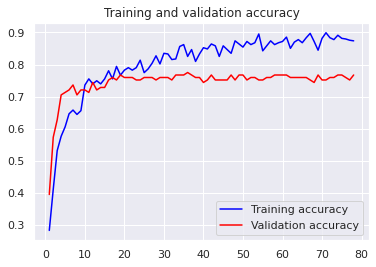

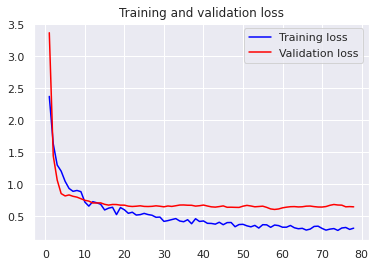

In [ ]:
# plot the loss and accuracy
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'blue', label='Training accuracy')
plt.plot(epochs, val_acc, 'red', label='Validation accuracy')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')

plt.legend()

plt.show()

In [ ]:
k_model=KerasClassifier(build_fn=create_model, epochs=100, batch_size=50, verbose=1)
kfold = KFold(n_splits=10, shuffle=True, random_state=13)
results=cross_val_score(k_model,train_features, y_train,cv=kfold,verbose=10, n_jobs = -1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   43.3s finished


In [ ]:
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 76.55% (4.25%)


In [ ]:
k_model=KerasClassifier(build_fn=create_model, epochs=100, batch_size=50, verbose=1)
kfold = KFold(n_splits=20, shuffle=True, random_state=13)
results1 =cross_val_score(k_model,train_features, y_train,cv=kfold,verbose=10, n_jobs = -1)
print("Baseline: %.2f%% (%.2f%%)" % (results1.mean()*100, results1.std()*100))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   57.6s
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Baseline: 77.51% (7.00%)


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.4min finished


In [ ]:
k_model=KerasClassifier(build_fn=create_model, epochs=100, batch_size=50, verbose=1)
kfold = KFold(n_splits=50, shuffle=True, random_state=13)
results1 =cross_val_score(k_model,train_features, y_train,cv=kfold,verbose=10, n_jobs = -1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.5min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.6min finished


In [ ]:
print("Baseline: %.2f%% (%.2f%%)" % (results1.mean()*100, results1.std()*100))

Baseline: 77.24% (9.61%)


### Model Prediction Class Wise

In [ ]:
classes = np.array(df.columns[1:])
proba = model.predict(test_features)

In [ ]:
all_5 = np.argsort(proba[0])
for i in range(5):
    print("{}".format(classes[all_5[i]])+" ({:.3})".format(proba[0][all_5[i]]*100))

category_Cigarette (0.00335)
category_Clear plastic bottle (0.00962)
category_Drink can (0.174)
category_Plastic film (1.02)
category_Plastic straw (98.8)
